# Exploring 1/3 octave filters


## 1. Core parameters

These parameters are the link between the offline feature extraction and the online embedded system filters. Only under the same circumstances can valid training data be generated. The parameters here define the treatment of the digital audio data.

In [1]:
fs = 48000                              # sample rate
fmin = 100                              # lowest f of interest
fmax = 12800                            # highest f of interest
oct_bw_ratio = 1/3                      # octave / amount of subdivisions
order = 8                               # order of octave filters

n_coeffs_p_section = 6                  # constant, definition of sos-matrix
n_sections = int(order/2)               # number of biquads (order 2 filters)
dec_stages = 4                          # number of decimations across bank
dec_ord = 10                            # order of decimation AA-filters

window_size = 1000                      # framing size. Corresponds to 125 ms
max_dur = 3                            # max duration of soun in s

test_wav = "demo_data/14387-9-0-11.wav"    # wav-file for testing

## 3. Filter exploration
In order to better understand `1/3 octave` filters a few visualizations can be helpful. Strangely, the amount of `python`-based modules for this filter-type is scarce, which led the author to create their own called [octafilt3r](https://github.com/jake-is-ESD-protected/octafilt3r). With this module, `octave`-filterbanks can be created, displayed and and applied as the main goal is to obtain spectrograms which were not sourced from any form of `FFT` but filtering and `RMS`-calculation.

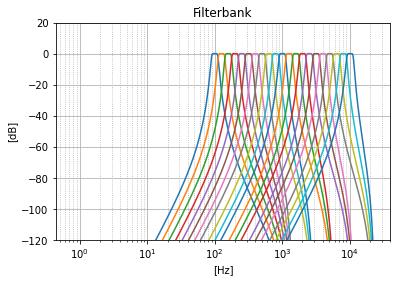

In [2]:
from octafilt3r import filter as o3f

sos_bands = o3f.oct_bank(fs, fmax, fmin, oct_bw_ratio, dec_stages, order=order, display=True)

Additionally, the `octafilt3r` module offers filters for **continuous** operation. This is only possible by passing the delay-lines along. The following code showcases the `decimator_filt` and `rolling_decimate` functions. Decimation is used to downsample data which is far below the `nyquist` frequency and would not profit from a high sampling rate anyways. Of course a `low pass` is needed to remove `aliasing`.

decimating 4 times:
sample rate of origninal file: 48000
sample rate after last decimation stage: 3000


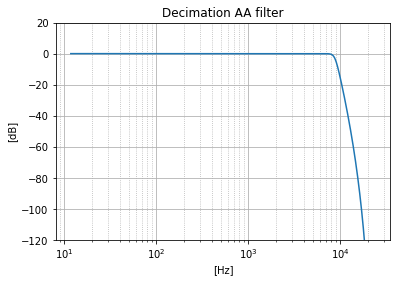

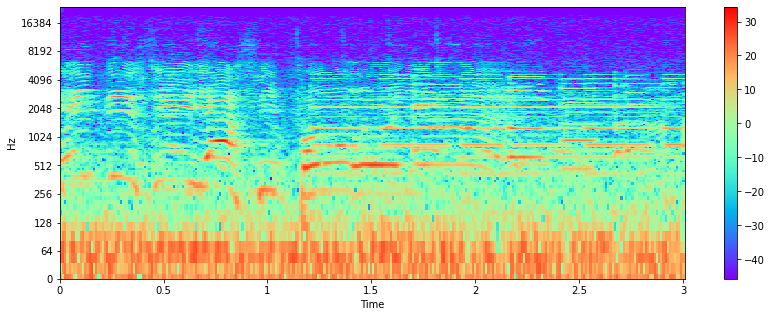

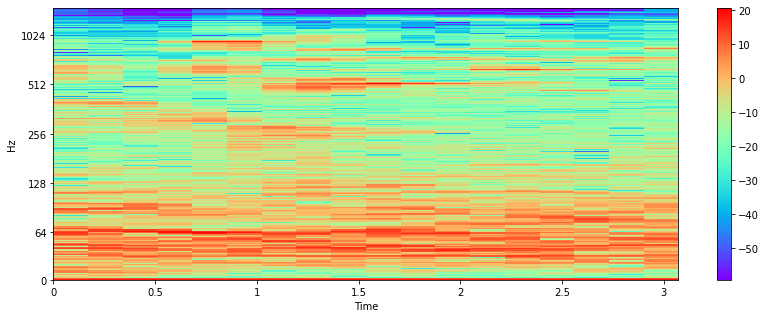

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import librosa as lr

def spec(y, sr):
    X = lr.stft(y)
    Xdb = lr.power_to_db(abs(X)**2, ref = 1)
    plt.figure(figsize=(14, 5))
    lr.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log', cmap = 'rainbow')
    plt.colorbar()

def plot(x, fs):
    plt.figure(figsize=(14, 5))
    librosa.display.waveplot(x, sr=fs, alpha=0.7)

wav, sr = lr.load(test_wav, sr=fs, duration=max_dur)
dec_sos = o3f._decimator_filt(fs, display=True)
zi = np.zeros((5, 2))

# decimate the signal 4 times:
factor = 4
new_wav = wav
for i in range(factor):
    new_wav, zi = o3f._rolling_decimate(new_wav, dec_sos, zi)

print(f'decimating {factor} times:')
print(f'sample rate of origninal file: {fs}')
spec(wav, fs)
print(f'sample rate after last decimation stage: {int(fs/(2 ** factor))}')
spec(new_wav, int(fs/(2 ** factor)))

## 4. Framing
Since continuous operation has to be simulated, **it is necessary** to keep all delay values of all involved filters, which includes all 31 filters + all decimators. Additionally, these have to enter their steady state. This means that all data has to be analyzed from `0` to `EOF` but can only be used from `settling time` to `EOF`. `Settling time` is dependent on frequency, with roughly `1s` for a low end of `100 Hz`. After the required `settling time` the filterbank should operate like a low-resolution, low-bin `STFT`.

window size: 2000


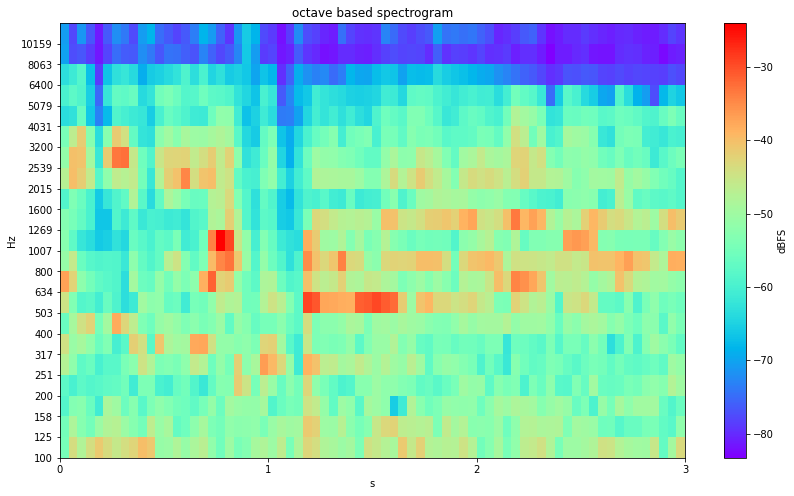

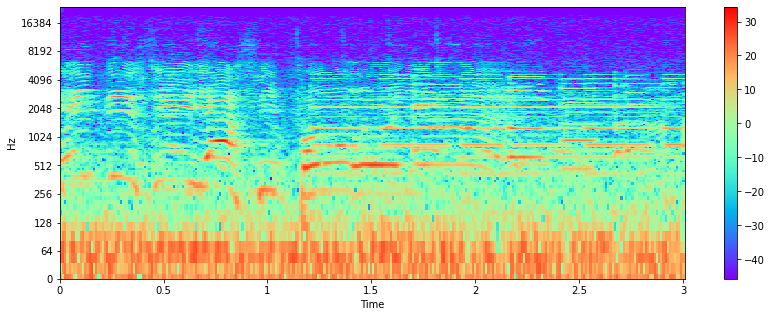

In [4]:
from octafilt3r import plot as o3p

window_size = 2000
print(f'window size: {window_size}')
feat, fcs = o3f.rolling_oct_bank(wav, fs, oct_bw_ratio, order, fmax, fmin, window_size)

o3p.oct_spectrogram(feat, fs, window_size, fmax=fmax, fmin=fmin, ratio=oct_bw_ratio)
spec(wav, fs)